In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.io import loadmat

In [2]:
mat_f = r'/home/zyou6474/Projects/python_util/test/data/LST_template.mat'
mat_data = loadmat(mat_f)

# Linear Stability Theory

In [3]:
# Input parameters 
N       = 384 # number of Chebyshev polynomials

R  = 180         # Reynolds number
kx = 0.5           # streamwise wavenumber
kz = 0           # spanwise wavenumber
Ri = 0.0        # Richardson number
Pr = 0.71        # Prantl number
Ra = 8*R*R/Pr*Ri # Rayleigh number
print('Rayleigh number is '+ str(Ra))

bf = 2   # set = 1 for Couette, 2 for Poiseuille, 3 for quiescent

Rayleigh number is 0.0


In [4]:
def dmat(N):
    D0 = np.cos(np.pi / (N-1) * np.arange(N)[np.newaxis, :] * np.arange(N)[:, np.newaxis])
    
    D1 = np.concatenate((np.zeros(shape=(1, N)), D0[0, :][np.newaxis, :], 4*D0[1, :][np.newaxis, :]), axis=0)
    D2 = np.concatenate((np.zeros(shape=(2, N)), 4*D0[1, :][np.newaxis, :]), axis=0)
    D3 = np.zeros(shape=(3, N))
    D4 = np.zeros(shape=(3, N))



    # create higher derivative matrices
    for j in range(2, N-1):
        
        D1= np.concatenate((D1, 2*j*D0[j, :][np.newaxis, :]+j*D1[j-1, :][np.newaxis, :]/(j-1)), axis=0)
        D2= np.concatenate((D2, 2*j*D1[j, :][np.newaxis, :]+j*D2[j-1, :][np.newaxis, :]/(j-1)), axis=0)
        D3= np.concatenate((D3, 2*j*D2[j, :][np.newaxis, :]+j*D3[j-1, :][np.newaxis, :]/(j-1)), axis=0)
        D4= np.concatenate((D4, 2*j*D3[j, :][np.newaxis, :]+j*D4[j-1, :][np.newaxis, :]/(j-1)), axis=0)
        
    return D0, D1, D2, D3, D4

In [5]:
# Set up grid and differentiation matrices
y_phys                = np.cos(np.linspace(0, np.pi, N))[np.newaxis, :]   # Generate Chebyshev grid for base flow solver
D0p,D1p,D2p,D3p,D4p = dmat(N)   # Chebyshev polynomials and derivatives at the Gauss points

In [6]:
def bounded_base(y_phys,N,bf):
    if bf == 1: # Couette flow
   
        U   = y_phys
        Up  = np.ones(shape=(1, N))
        Upp = np.zeros(shape=(1, N))
        T   = y_phys
        Tp  = np.zeros(shape=(1, N))
        
    elif bf == 2 : # Poiseuille flow
        
        U   = (1 - y_phys**2)
        Up  = -2*y_phys
        Upp = -2*np.ones(shape=(1, N))
        T   = np.zeros(shape=(1, N))
        Tp  = np.zeros(shape=(1, N))
        
    elif bf == 3: # quiescent flow
        
        U   = np.zeros(shape=(1, N))
        Up  = np.zeros(shape=(1, N))
        Upp = np.zeros(shape=(1, N))
        T   = y_phys
        Tp  = np.ones(shape=(1, N))
    else:
        print('Need to select bf = 1 or 2')
        
        
    return U,Up,Upp,T,Tp

In [7]:
# Find the base flow
[U,Up,Upp,T,Tp] = bounded_base(y_phys,N,bf)

In [8]:
def Operator(kx,kz,R,Pr,Ri,U,Up,Upp,Tp,D0,D1,D2,D4):
    # Useful variables --------------------------------------------------------
    k2 = kx**2 + kz**2;       # wavenumber^2
    N  = U.shape[1]
    M  =  np.ones(shape=(N, 1)) # matrix for mean flow variables 
    er = -200*1j           # for spurious eigenvalues from BCs

    LSQ = -1j*kx*(U*M)*D0 + (1/R)*(D2-k2*D0)
    LOS = -1j*kx*(U*M)*(D2-k2*D0) + 1j*kx*(Upp*M)*D0 + (1/R)*(D4-(2*k2*D2)+((k2**2)*D0))
    A32 = -1j*kx*(U*M)*D0 + (1/R/Pr)*(D2-k2*D0)
    
    A = np.block([[LOS.T, np.zeros((N, N)), -Ri*k2*D0.T],[-1j*kz*(Up*M*D0).T , LSQ.T, np.zeros((N, N))],[-(Tp*M*D0).T, np.zeros((N, N)), A32.T]]).T

    B = np.block([[D2.T-k2*D0.T, np.zeros((N, N)), np.zeros((N, N))], [np.zeros((N, N)), D0.T, np.zeros((N, N))], [np.zeros((N, N)),  np.zeros((N, N)), D0.T]]).T

    B[0:N, 0] = D0[:, 0]
    B[0:N, 1] = D1[:, 0] # v, Dv at y = top
    B[0:N, N-2] = D1[:, N-1]
    B[0:N, N-1] = D0[:, N-1] # v, Dv at y = bot

    # apply boundary condtions to top and bottom 2 rows (i.e. v = Dv = 0)
    A[0:N, 0] = er*D0[:, 0]       # vanishing in the free stream
    A[0:N, 1] = er*D1[:, 0]       # vanishing in the free stream
    A[0:N, N-2] = er*D1[:, N-1]   # gradient vanishing at wall (no slip)
    A[0:N, N-1] = er*D0[:, N-1]   # no penetration at wall

    # clear the rows to apply Squire boundary conditions ----------------------
    A[:, N] = 0
    A[:, 2*N-1] = 0

    # apply Squire boundary conditions (eta = 0 at y=top,bot)
    A[N:2*N, N] = er*D0[:, 0]
    A[N:2*N, 2*N-1] = er*D0[:, N-1] 

    # apply temperature boundary conditions
    A[:, 2*N] = 0
    A[:, 3*N-1] = 0

    A[2*N:3*N, 2*N] = er*D0[:, 0]
    A[2*N:3*N, 3*N-1] = er*D0[:, N-1]
    return A, B

In [9]:
# Find eigenvalues of stability operators
A, B = Operator(kx,kz,R,Pr,Ri,U,Up,Upp,Tp,D0p,D1p,D2p,D4p)



In [10]:
# find eigenvalues
omega, q = np.linalg.eig(np.linalg.inv(B) @ A)

omega = 1j*omega   # eigenvalues omega in vector form

In [11]:
# remove bad eigenvalues
sp = np.logical_and(abs(omega)>1e-10, abs(omega)<50)

omega = omega[sp]
q = q[sp]

In [12]:
# remove bad eigenvalues
sp_mat = np.logical_and(abs(mat_data['omega'])>1e-10, abs(mat_data['omega'])<50)

mat_data['omega'] = mat_data['omega'][sp_mat]
mat_data['q'] = mat_data['q'][:, np.squeeze(sp_mat)]

(-10.0, 5.0)

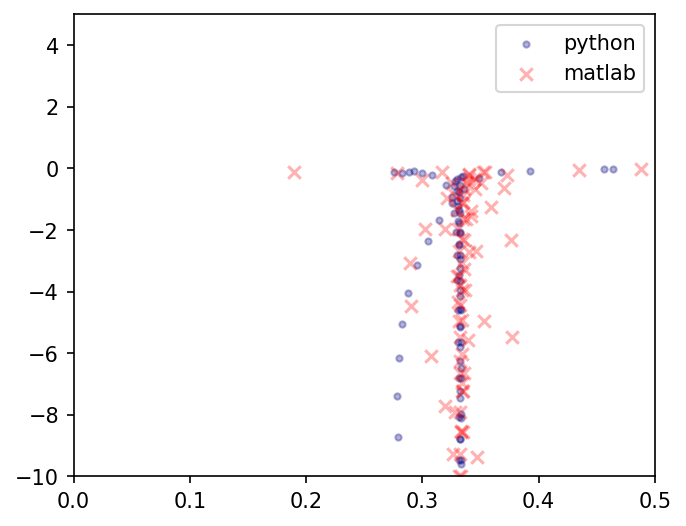

In [15]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
ax.scatter(np.real(omega), np.imag(omega), marker='.', color='navy', alpha=0.3, label='python')
ax.scatter(np.real(mat_data['omega']), np.imag(mat_data['omega']), marker='x', color='red', alpha=0.3, label='matlab')
ax.legend()
ax.set_xlim(0, 0.5)
ax.set_ylim(-10, 5)